In [1]:
import sys
sys.path.append('03_MNIST_Diffusion')
from diffusion_helper import *
from diffusion_model import *

c:\Users\Lukas\miniconda3\envs\ml_train\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 8.98MB/s]


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 254kB/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.45MB/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 4, 9, 9, 7, 2, 3, 0])



c:\Users\Lukas\miniconda3\envs\ml_train\Lib\site-packages\torch\cuda\memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
c:\Users\Lukas\miniconda3\envs\ml_train\Lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


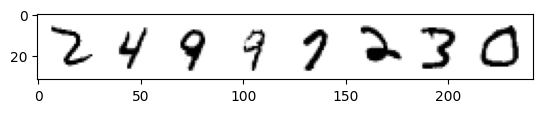

In [4]:
# Load the MNIST dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=20, beta_schedule='squaredcos_cap_v2')

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()

100%|██████████| 469/469 [00:54<00:00,  8.58it/s]


Finished epoch 0. Average of the last 100 loss values: 0.046972


100%|██████████| 469/469 [00:53<00:00,  8.70it/s]


Finished epoch 1. Average of the last 100 loss values: 0.041900


100%|██████████| 469/469 [00:53<00:00,  8.78it/s]


Finished epoch 2. Average of the last 100 loss values: 0.041085


100%|██████████| 469/469 [00:54<00:00,  8.55it/s]


Finished epoch 3. Average of the last 100 loss values: 0.039327


100%|██████████| 469/469 [00:55<00:00,  8.45it/s]


Finished epoch 4. Average of the last 100 loss values: 0.038598


100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


Finished epoch 5. Average of the last 100 loss values: 0.037887


100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Finished epoch 6. Average of the last 100 loss values: 0.037694


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


Finished epoch 7. Average of the last 100 loss values: 0.036811


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


Finished epoch 8. Average of the last 100 loss values: 0.036497


100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


Finished epoch 9. Average of the last 100 loss values: 0.035869


100%|██████████| 469/469 [00:55<00:00,  8.39it/s]


Finished epoch 10. Average of the last 100 loss values: 0.036124


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


Finished epoch 11. Average of the last 100 loss values: 0.036099


100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


Finished epoch 12. Average of the last 100 loss values: 0.035795


100%|██████████| 469/469 [00:55<00:00,  8.41it/s]


Finished epoch 13. Average of the last 100 loss values: 0.035622


100%|██████████| 469/469 [00:56<00:00,  8.30it/s]

Finished epoch 14. Average of the last 100 loss values: 0.035282


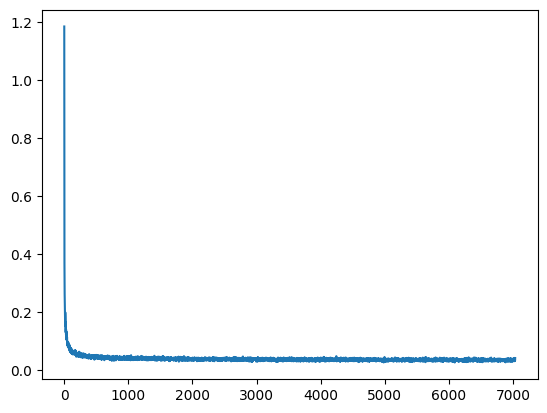

In [5]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 15

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 19, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [8]:
# Save the model
model_save_path = 'models/trained_unet.pth'
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'losses': losses,
    'epoch': n_epochs
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/trained_unet.pth


In [6]:
# Load a new model if avaliable:
#net, opt, losses = load_trained_model('models/trained_unet.pth', device)

In [9]:
print_detailed_unet_structure(net)


=== Complete ClassConditionedUnet Structure ===

Embedding Layer:

UNet Model:
Input Processing:
  Sample Size: 28
  In Channels: 5
  Out Channels: 1

Down Blocks:

Down Block 1: DownBlock2D
  resnets: ModuleList
    0: ResnetBlock2D
      norm1: GroupNorm
      conv1: Conv2d
        in_channels: 32
        out_channels: 32
        kernel_size: (3, 3)
        stride: (1, 1)
        padding: (1, 1)
      time_emb_proj: Linear
        in_features: 128
        out_features: 32
      norm2: GroupNorm
      dropout: Dropout
      conv2: Conv2d
        in_channels: 32
        out_channels: 32
        kernel_size: (3, 3)
        stride: (1, 1)
        padding: (1, 1)
      nonlinearity: SiLU
    1: ResnetBlock2D
      norm1: GroupNorm
      conv1: Conv2d
        in_channels: 32
        out_channels: 32
        kernel_size: (3, 3)
        stride: (1, 1)
        padding: (1, 1)
      time_emb_proj: Linear
        in_features: 128
        out_features: 32
      norm2: GroupNorm
      dropout: D

j:\Master thesis\code_v2\03_MNIST_Diffusion\diffusion_helper.py:84: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  print(f"  In Channels: {model.model.in_channels}")
j:\Master thesis\code_v2\03_MNIST_Diffusion\diffusion_helper.py:85: FutureWarning: Accessing config attribute `out_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'out_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.out_channels'.
  print(f"  Out Channels: {model.model.out_channels}")


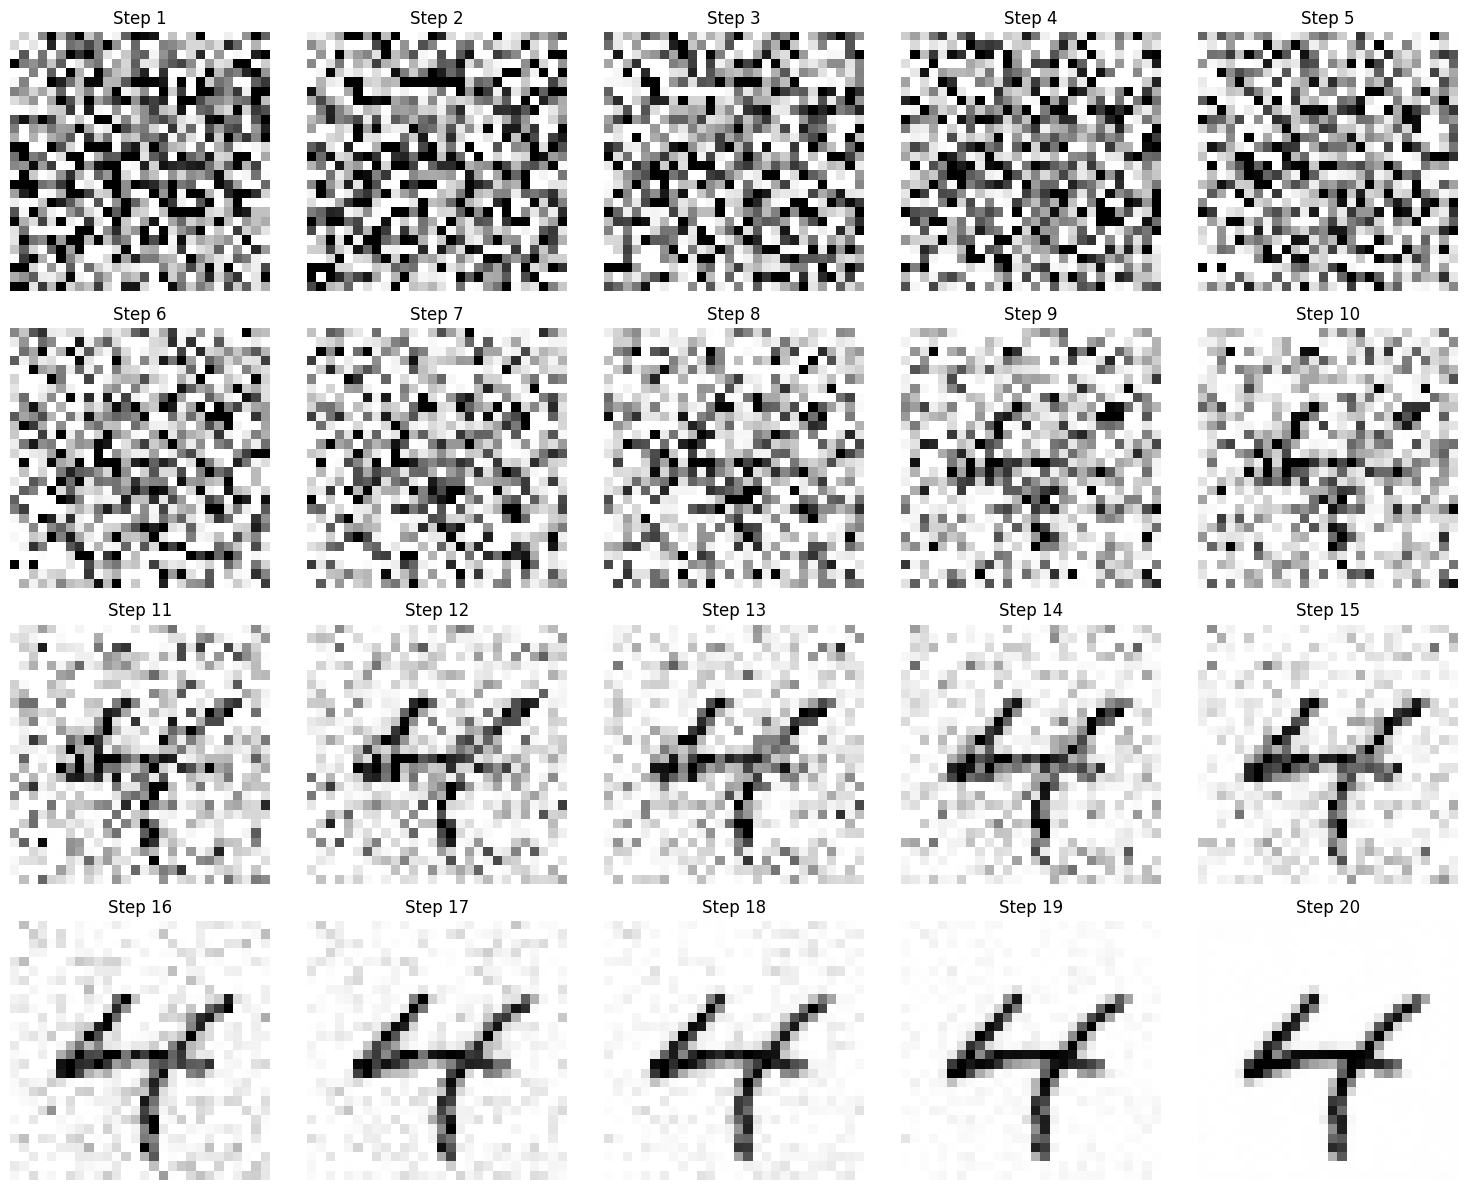

In [15]:
# Example usage of the trained model to generate an image
label = 4  # Specify the digit label
final_img, steps = generate_image_with_all_steps(noise_scheduler, net, label)

# Display all steps in a grid
fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # 4x5 grid for 20 steps
for i, ax in enumerate(axes.flatten()):
    ax.imshow(steps[i].squeeze(), cmap='Greys')
    ax.axis('off')
    ax.set_title(f"Step {i+1}")
plt.tight_layout()
plt.show()

In [10]:
save_dir = 'unet_activations'
collect_activations(net, 
                   save_dir=save_dir,
                   device=device,
                   batch_size=2000,
                   save_inputs=True,
                   save_outputs=True,
                   save_first_timestep=True,
                   save_last_timestep=True)

Registered 4 hooks for middle block attention layers
Processing batch 30: samples 58000-60000 (100.0%)
Finished collecting activations!
Data saved to unet_activations/ in chunks of 2000 samples
Files saved:
- inputs_XXXX.npy: Input images
- labels_XXXX.npy: Input labels
- activations_first_XXXX.npy: First timestep activations
- activations_last_XXXX.npy: Last timestep activations
- outputs_XXXX.npy: Final outputs
where XXXX represents the cumulative sample count


In [11]:
inputs_all = combine_chunks('unet_activations', 'inputs', delete_chunks=True)
last_timestep_all = combine_chunks('unet_activations', 'activations_last', delete_chunks=True)
first_timestep_all = combine_chunks('unet_activations', 'activations_first', delete_chunks=True)
labels_all = combine_chunks('unet_activations', 'labels', delete_chunks=True)
outputs_all = combine_chunks('unet_activations', 'outputs', delete_chunks=True)

Loading inputs chunks...
Loaded chunk ending at 60000
Combining 30 chunks...
Saving combined file to unet_activations\inputs_all.npy
Deleting chunk files...
Done! Combined shape: (60000, 1, 28, 28)
Loading activations_last chunks...
Loaded chunk ending at 60000
Combining 30 chunks...
Saving combined file to unet_activations\activations_last_all.npy
Deleting chunk files...
Done! Combined shape: (60000, 12544)
Loading activations_first chunks...
Loaded chunk ending at 60000
Combining 30 chunks...
Saving combined file to unet_activations\activations_first_all.npy
Deleting chunk files...
Done! Combined shape: (60000, 12544)
Loading labels chunks...
Loaded chunk ending at 60000
Combining 30 chunks...
Saving combined file to unet_activations\labels_all.npy
Deleting chunk files...
Done! Combined shape: (60000,)
Loading outputs chunks...
Loaded chunk ending at 60000
Combining 30 chunks...
Saving combined file to unet_activations\outputs_all.npy
Deleting chunk files...
Done! Combined shape: (60

In [12]:
# Only if data blocks have already beedn saved and reduced!

# inputs_all = np.load('unet_activations/inputs_all.npy')
# labels_all = np.load('unet_activations/labels.npy')
# last_timestep_all = np.load('unet_activations/activations_first_all.npy')
# first_timestep_all = np.load('unet_activations/activations_last_all.npy')
# outputs_all = np.load('unet_activations/outputs_all.npy')

In [14]:
print(inputs_all[0].shape)
print(labels_all.shape)
print(first_timestep_all[0].shape)
print(last_timestep_all[0].shape)
print(outputs_all[0].shape)

(1, 28, 28)
(60000,)
(12544,)
(12544,)
(1, 28, 28)


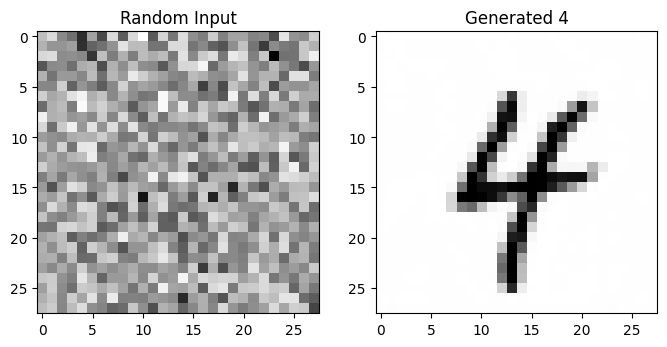

In [22]:
# Example usage:
label = 4  # Generate sample for digit 5
input_noise, output, first_step, last_step = get_new_sample(net, label, noise_scheduler)

# Visualize input and output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(input_noise[0,0], cmap='Greys')
ax1.set_title('Random Input')
ax2.imshow(output[0,0], cmap='Greys')
ax2.set_title(f'Generated {label}')
plt.show()

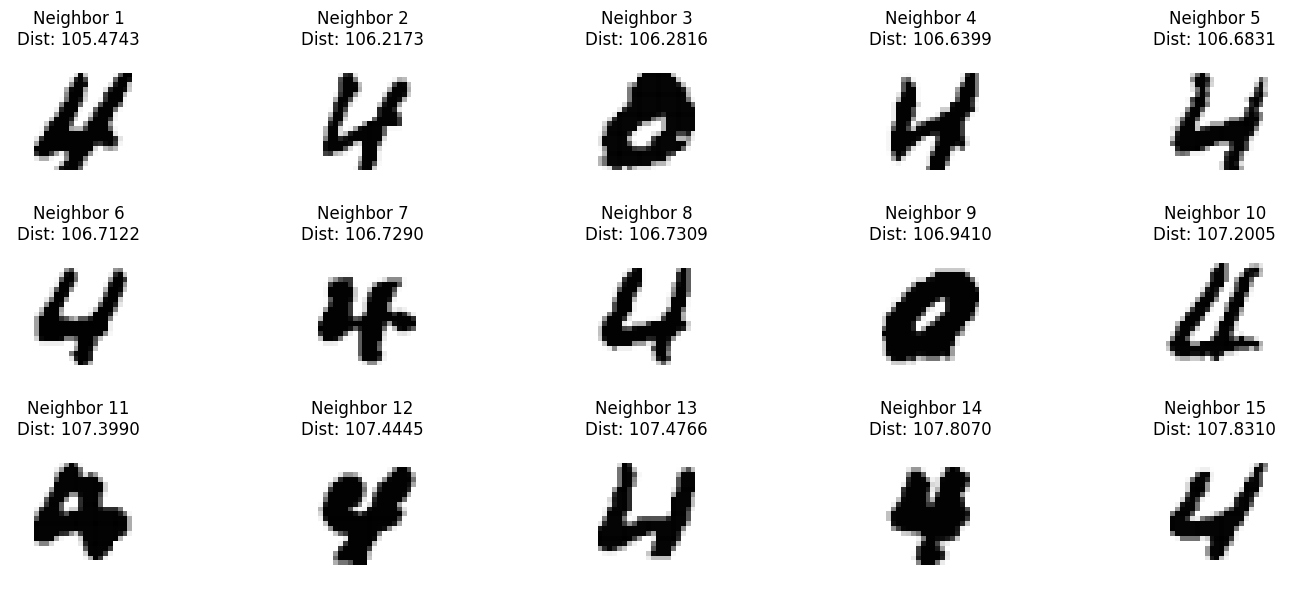

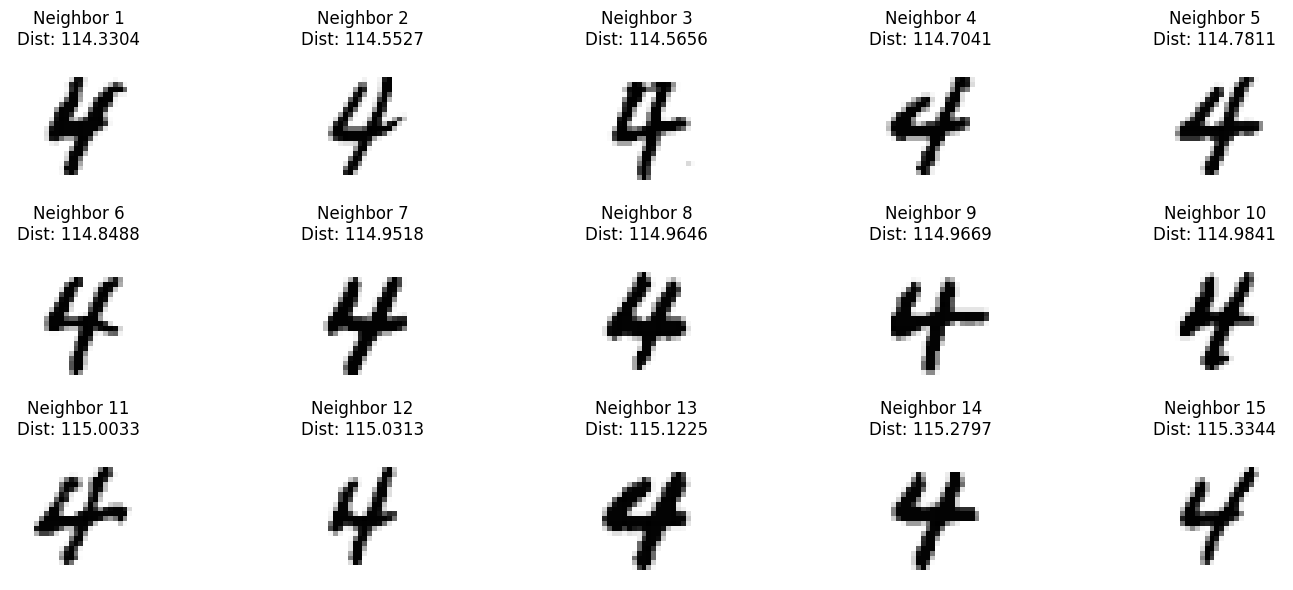

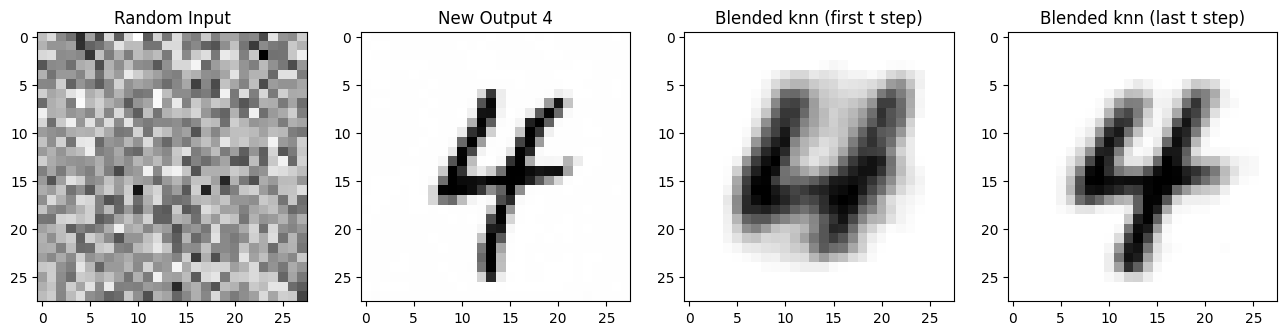

In [23]:
# Example usage:
indices, distances = knn_search(query=first_step, dataset=first_timestep_all, k=15)
#best_k, indices, distances, dist = find_optimal_k(query=first_step, dataset=first_timestep_all, k_range=(1, 35), step=1, reference=first_step)
visualize_neighbors(inputs_all, indices, distances)

# Finding KNN in inputs
blended_input_f, in_dist = blend_samples(dataset=inputs_all, indices=indices, distances=distances, reference=input_noise)
blended_output_f, out_dist = blend_samples(dataset=outputs_all, indices=indices, distances=distances, reference=output)

# Example usage:
indices, distances = knn_search(query=last_step, dataset=last_timestep_all, k=15)
#best_k, indices, distances, dist = find_optimal_k(query=last_step, dataset=last_timestep_all, k_range=(1, 35), step=1, reference=last_step)
visualize_neighbors(inputs_all, indices, distances)

# Finding KNN in inputs
blended_input_l, in_dist = blend_samples(dataset=inputs_all, indices=indices, distances=distances, reference=input_noise)
blended_output_l, out_dist = blend_samples(dataset=outputs_all, indices=indices, distances=distances, reference=output)

# Visualize input and output
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6))
ax1.imshow(input_noise[0,0], cmap='Greys')
ax1.set_title('Random Input')
ax2.imshow(output[0,0], cmap='Greys')
ax2.set_title(f'New Output {label}')
ax3.imshow(blended_input_f[0], cmap='Greys')
ax3.set_title(f'Blended knn (first t step)')
ax4.imshow(blended_input_l[0], cmap='Greys')
ax4.set_title(f'Blended knn (last t step)')
plt.show()